In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

In [2]:
# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V

from utils.topic_comparison import compare_topic_queryset, save_res, sort_matrix, draw_score_matrix
from utils.topic_comparison import save_topic_list_as_table, draw_bipartite_topic_graph, bipartite_graph_from_matrix

## Topic Model Run ##

In [10]:
user1, created =  User.objects.get_or_create(username='leey', email='lee@mcc-berlin.net')
print(user1)
user1.save()

leey


In [11]:
# simple search for utterances
par_search_tei, created = pm.Search.objects.get_or_create(
                title="Kohle tei utterance",
                text="kohle",
                creator=user1,
                document_source="GermaParlTEI",
                search_object_type=2)
par_search_tei.save()
if created:
    print("doing search")
do_search(par_search_tei.id)
print(par_search_tei.par_count)
print(par_search_tei.utterance_count)
print(par_search_tei.runstats_set.all())

3281 utterances with search kohle
35275
3281
35298
3284
<QuerySet [<RunStats: RunStats object (967)>, <RunStats: RunStats object (966)>, <RunStats: RunStats object (964)>]>


In [12]:
# number of topics
K = [20,30,40,50]

In [13]:
# K= 20 to 50 for static LDA
for i in K:
    run_tm(par_search_tei.id, i, method='LD')

creating term frequency matrix (5.191987991333008)
save terms to db (71.37783455848694)
running Latent Dirichlet Allocation (123.41904854774475)
saving document topic matrix to db (256.00026178359985)
topic model run done (268.15170192718506)
creating term frequency matrix (5.358798265457153)
save terms to db (72.54050064086914)
running Latent Dirichlet Allocation (123.61635541915894)
saving document topic matrix to db (289.92709946632385)
topic model run done (308.1746199131012)
creating term frequency matrix (5.396486759185791)
save terms to db (71.2847809791565)
running Latent Dirichlet Allocation (123.62917232513428)
saving document topic matrix to db (343.2549510002136)
topic model run done (368.6121850013733)
creating term frequency matrix (5.613050699234009)
save terms to db (73.04538607597351)
running Latent Dirichlet Allocation (125.8684389591217)
saving document topic matrix to db (362.3608593940735)
topic model run done (394.2270016670227)


## Different Number of Topics ##

### LDA, K = 20, 30 

In [42]:
# Compares LDA methods for K=20 and K= 30
K1 = 20
K2 = 30
method = 'LD'
search_word = "Kohle"
run_id1 = RunStats.objects.get(psearch__title="{} tei utterance".format(search_word), method=method, K=K1).run_id
run_id2 = RunStats.objects.get(psearch__title="{} tei utterance".format(search_word), method=method, K=K2).run_id

stat1 = RunStats.objects.get(pk=run_id1)
topics1 = Topic.objects.filter(run_id=stat1.parent_run_id).order_by('-score')

stat2 = RunStats.objects.get(pk=run_id2)
topics2 = Topic.objects.filter(run_id=stat2.parent_run_id).order_by('-score')

['run_1045_topics_20', 'scores_1045', 'similarity_1045-1046', 'run_1046_topics_30', 'scores_1046']
C2:C30
matching sum:	106.0
max rows:	110.0
max cols:	148.0


0

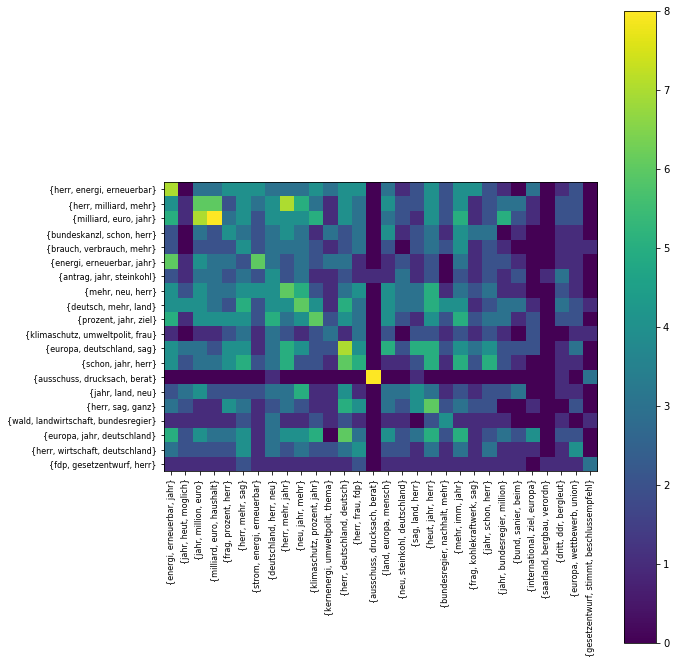

In [43]:
# Compares LDA methods for K=20 and K= 30
% matplotlib inline

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

draw_score_matrix(score_matrix, topics1, topics2, match=True, filename="topword_score_matrix_{}_{}_K{}_{}.png".format(search_word, method, K1, K2))

In [44]:
from termcolor import colored

def print_topics(topics1, topics2):
    
    for i in range(len(topics1)):
        sim_score = len(set(topics1[i].top_words).intersection(set(topics2[i].top_words)))

        if topics1[i].top_words == topics2[i].top_words:
            print("#{}: score: {}, matching".format(i, sim_score))
        elif sim_score > 5:
            print("#{}: score: {}, not matching".format(i, sim_score))
        else:
            print(colored("#{}: score: {}, not matching".format(i, sim_score), 'red'))

        print("{}\n{}".format(", ".join(topics1[i].top_words), ", ".join(topics2[i].top_words)))

matrix1, permutation1 = sort_matrix(score_matrix)
topic_list1 = [topics1[int(permutation1[i])] for i in range(len(topics1))]
        
print_topics(topic_list1, topics2)

matching sum:	106.0
max rows:	110.0
max cols:	148.0
#0: score: 7, not matching
herr, energi, erneuerbar, klimaschutz, mehr, deutschland, prozent, sag, emissionshandel, kohlekraftwerk
energi, erneuerbar, jahr, herr, prozent, deutschland, sag, energiepolit, kraftwarmekoppl, mehr
#1: score: 1, not matching
herr, milliard, mehr, haushalt, jahr, land, euro, gross, steuerreform, deutschland
jahr, heut, moglich, mocht, gesetz, unternehm, bereit, regel, ganz, deutsch
#2: score: 7, not matching
milliard, euro, jahr, prozent, herr, million, haushalt, deutschland, hoh, mehr
jahr, million, euro, bereich, land, haushalt, neu, mehr, herr, prozent
#3: score: 2, not matching
bundeskanzl, schon, herr, land, mehr, frag, imm, kolleg, dafur, geb
milliard, euro, haushalt, jahr, herr, okosteu, subvention, hoh, mehr, prozent
#4: score: 2, not matching
brauch, verbrauch, mehr, geht, herr, imm, schon, beispiel, wirklich, bundesregier
frag, prozent, herr, sag, neu, deutschland, schon, kolleg, punkt, gesagt
#5: 

matching sum:	106.0
max rows:	110.0
max cols:	148.0


0

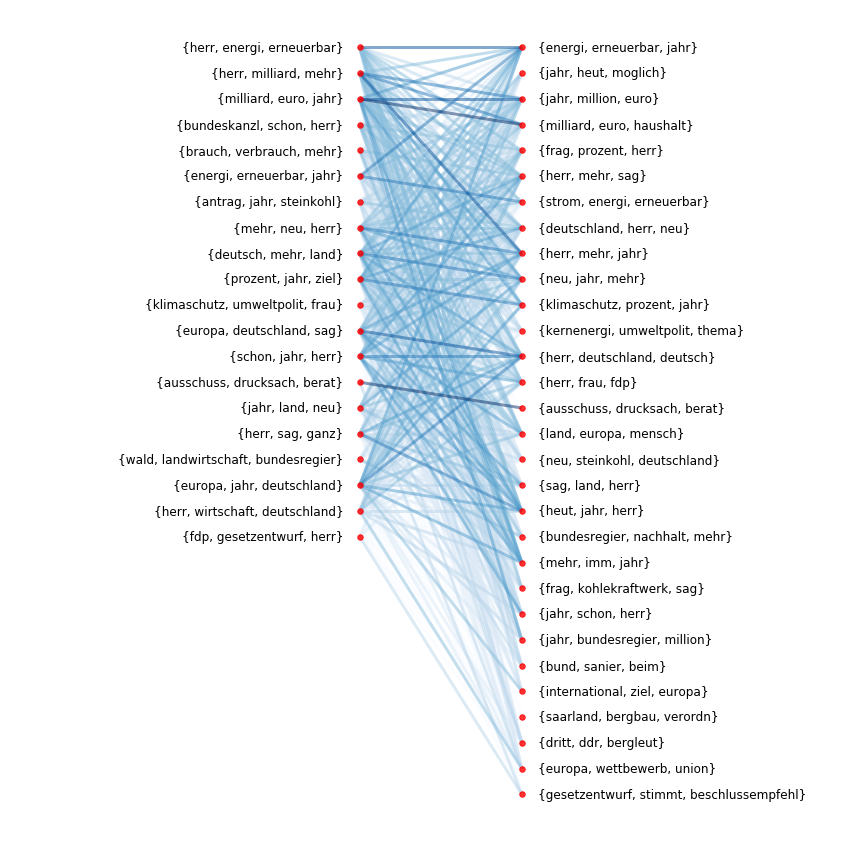

In [45]:
matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K1)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_{}_{}_K{}_K{}_topword_score'.format(search_word, method, K1, K2))

### LDA, K = 30, 40

In [46]:
# Compares LDA methods for K=20 and K= 30
K1 = 30
K2 = 40
method = 'LD'
search_word = "Kohle"
run_id1 = RunStats.objects.get(psearch__title="{} tei utterance".format(search_word), method=method, K=K1).run_id
run_id2 = RunStats.objects.get(psearch__title="{} tei utterance".format(search_word), method=method, K=K2).run_id

stat1 = RunStats.objects.get(pk=run_id1)
topics1 = Topic.objects.filter(run_id=stat1.parent_run_id).order_by('-score')

stat2 = RunStats.objects.get(pk=run_id2)
topics2 = Topic.objects.filter(run_id=stat2.parent_run_id).order_by('-score')

['run_1046_topics_30', 'scores_1046', 'similarity_1046-1047', 'run_1047_topics_40', 'scores_1047']
C2:C40
matching sum:	144.0
max rows:	154.0
max cols:	187.0


0

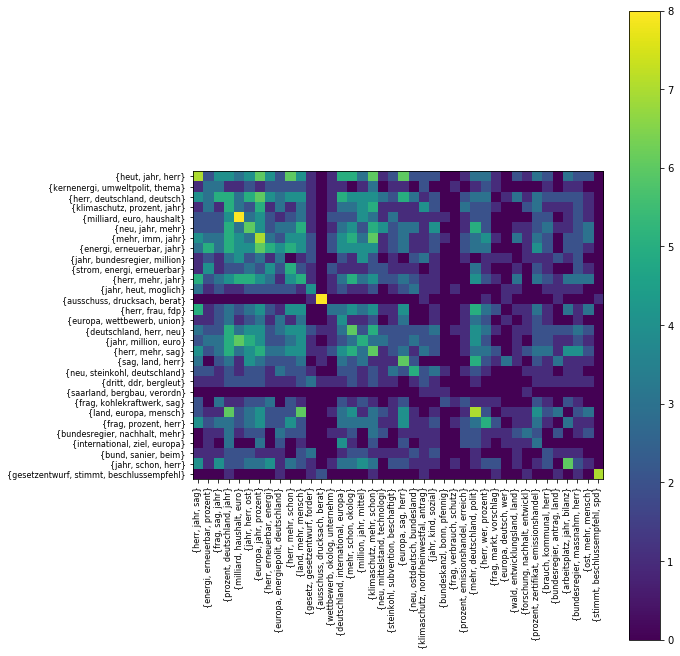

In [47]:
# Compares LDA methods for K=20 and K= 30
% matplotlib inline

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

draw_score_matrix(score_matrix, topics1, topics2, match=True, filename="topword_score_matrix_{}_{}_K{}_{}.png".format(search_word, method, K1, K2))

In [48]:
matrix1, permutation1 = sort_matrix(score_matrix)
topic_list1 = [topics1[int(permutation1[i])] for i in range(len(topics1))]
        
print_topics(topic_list1, topics2)

matching sum:	144.0
max rows:	154.0
max cols:	187.0
#0: score: 7, not matching
heut, jahr, herr, sag, mehr, gesagt, ganz, nordrheinwestfal, deutschland, schon
herr, jahr, sag, heut, fdp, gesagt, polit, schon, ganz, dam
#1: score: 3, not matching
kernenergi, umweltpolit, thema, bereich, energi, klimaschutz, frag, kolleg, herr, wirtschaft
energi, erneuerbar, prozent, deutschland, jahr, bereich, kernenergi, strom, nutzung, gross
#2: score: 5, not matching
herr, deutschland, deutsch, jahr, ganz, gibt, sag, beispiel, land, prozent
frag, sag, jahr, glaub, gibt, ganz, bereich, herr, richtig, gut
#3: score: 5, not matching
klimaschutz, prozent, jahr, bundesregier, ziel, erreich, million, tonn, mehr, deutschland
prozent, deutschland, jahr, wichtig, europa, mehr, international, land, bundesregier, herr
#4: score: 8, not matching
milliard, euro, haushalt, jahr, herr, okosteu, subvention, hoh, mehr, prozent
milliard, haushalt, euro, jahr, herr, prozent, steuerreform, hoh, mehr, wachstum
#5: score:

matching sum:	144.0
max rows:	154.0
max cols:	187.0


0

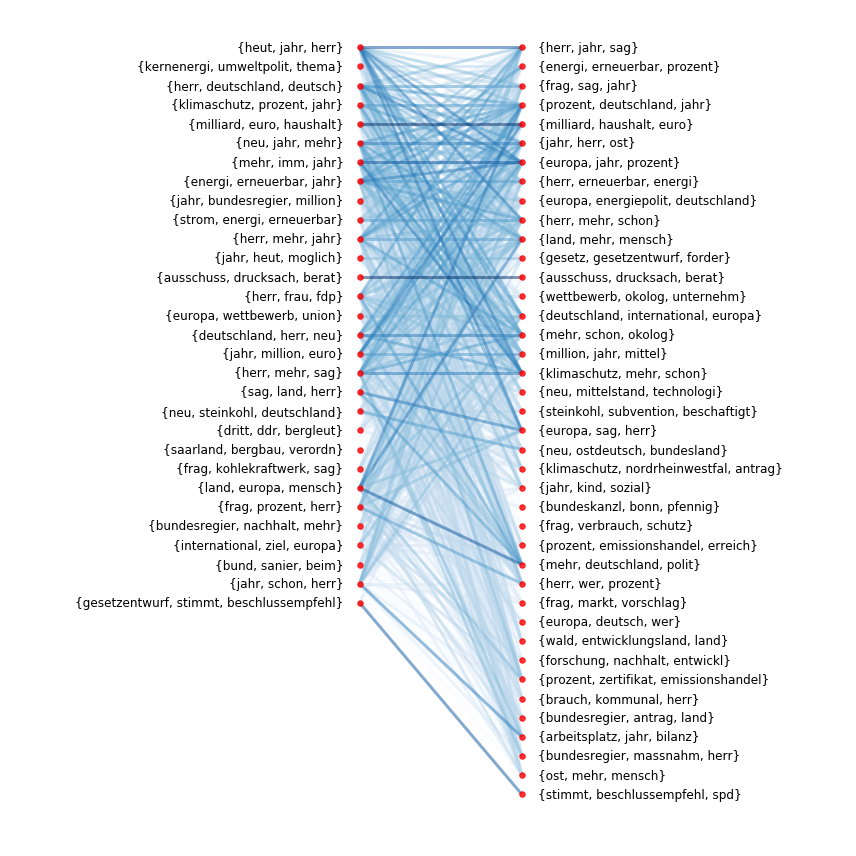

In [49]:
matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K1)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_{}_{}_K{}_K{}_topword_score'.format(search_word, method, K1, K2))

### LDA, K = 40, 50

In [38]:
# Compares LDA methods for K=20 and K= 30
K1 = 40
K2 = 50
method = 'LD'
search_word = "Kohle"
run_id1 = RunStats.objects.get(psearch__title="{} tei utterance".format(search_word), method=method, K=K1).run_id
run_id2 = RunStats.objects.get(psearch__title="{} tei utterance".format(search_word), method=method, K=K2).run_id

stat1 = RunStats.objects.get(pk=run_id1)
topics1 = Topic.objects.filter(run_id=stat1.parent_run_id).order_by('-score')

stat2 = RunStats.objects.get(pk=run_id2)
topics2 = Topic.objects.filter(run_id=stat2.parent_run_id).order_by('-score')

['run_1047_topics_40', 'scores_1047', 'similarity_1047-1048', 'run_1048_topics_50', 'scores_1048']
C2:C50
matching sum:	183.0
max rows:	189.0
max cols:	230.0


0

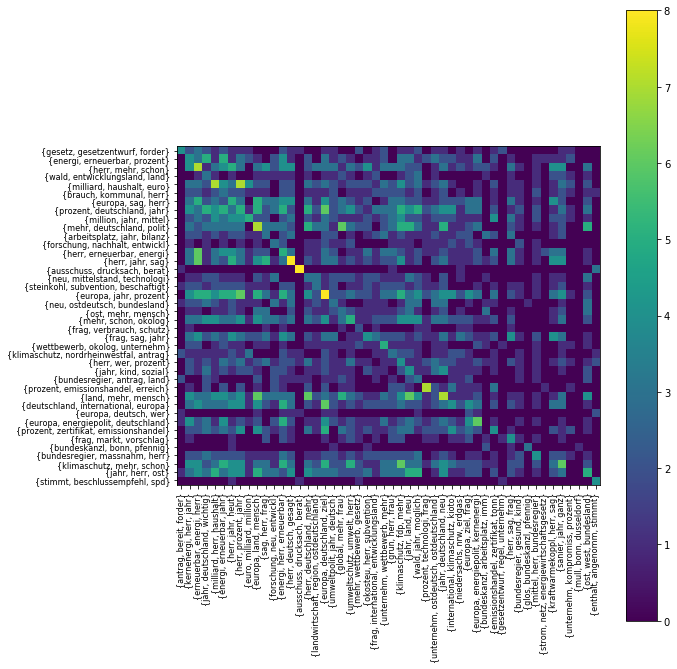

In [39]:
# Compares LDA methods for K=20 and K= 30
% matplotlib inline

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

draw_score_matrix(score_matrix, topics1, topics2, match=True, filename="topword_score_matrix_{}_{}_K{}_{}.png".format(search_word, method, K1, K2))

matching sum:	183.0
max rows:	189.0
max cols:	230.0


0

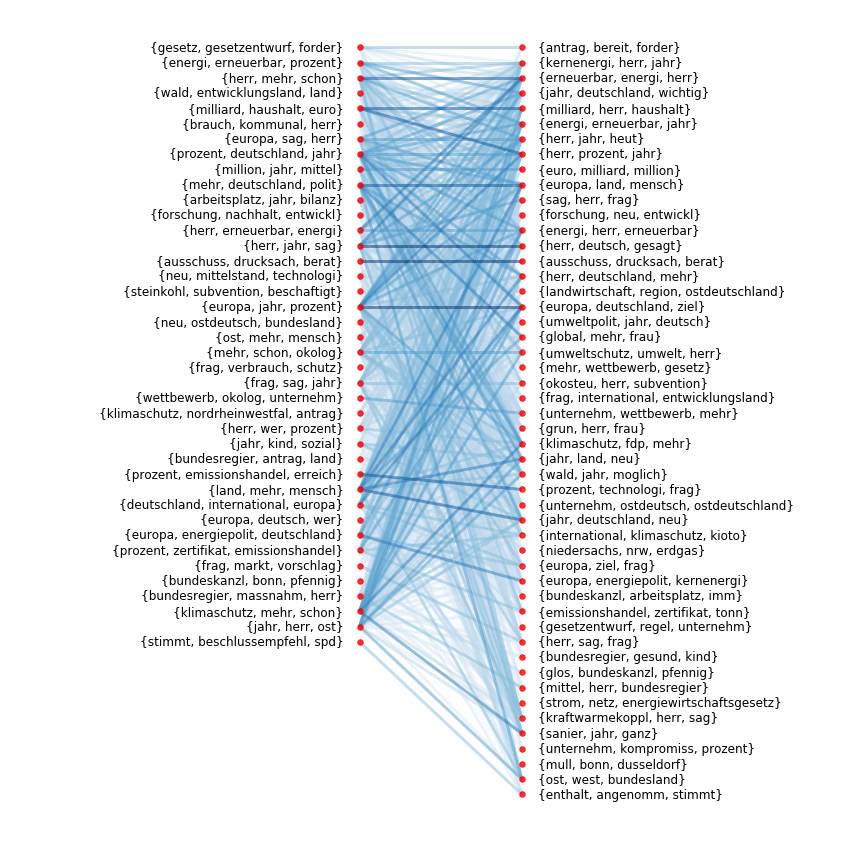

In [41]:
matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K1)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_{}_{}_K{}_K{}_topword_score'.format(search_word, method, K1, K2))